In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from pydmd import HODMD
import matplotlib.gridspec as gs
import numpy.matlib as mb

import ipywidgets as widgets

In [2]:
#Read Data
df = pd.read_csv("C:/Users/Vishnu/Downloads/HODMD_COVID (2)/HODMD_COVID/Dataset/IndiaStateWise/Cleaned_each_day.csv",header=1)
df = df.fillna(method="ffill")
df = df.drop("0",axis=1)
daily_cases = df.ewm(span=40,axis=0).mean().T
daily_cases.drop(["UT","DD"],axis=0,inplace=True)
cumulative_cases = daily_cases.cumsum(axis=1)
states = daily_cases.T.columns
daily_cases.shape

(36, 1028)

In [3]:
states

Index(['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DL', 'GA', 'GJ', 'HR',
       'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH', 'MN', 'ML', 'MZ',
       'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG', 'TR', 'UP', 'WB', 'UN'],
      dtype='object')

In [4]:


class Experiment():
    
    def __init__(self, X,
                 train_params = {"start_day":0, "train_days":40, "pred_days":5},
                 HODMD_params = { "svd_rank":0, "tlsq_rank":0, "exact":False, "opt":False,
                 "rescale_mode":None, "forward_backward":False, "d":35,
                 "sorted_eigs":False, "reconstruction_method":"first",
                 "svd_rank_extra":0},
                row_mask=None):
        self.start_day = train_params["start_day"]
        self.train_days = train_params["train_days"]
        self.pred_days = train_params["pred_days"]
        self.X = X
        self.DMD = HODMD(**HODMD_params)
        
        self.row_mask = row_mask
        self.train_data ,self.ground_truth = Experiment.train_test_split(self.X,self.train_days,self.pred_days,self.start_day,self.row_mask)
        self.metrics = {}

    @staticmethod
    def train_test_split(df,train_days,pred_days,start_day,row_mask=None):
        if row_mask==None:
            train = df.loc[:,start_day:start_day+train_days-1]
            test = df.loc[:, start_day+train_days: start_day+train_days+pred_days-1]
        else:
            try:
                train = df.loc[row_mask,start_day:start_day+train_days-1]
                test = df.loc[row_mask, start_day+train_days: start_day+train_days+pred_days-1]
            except:
                raise Exception("mask should be compatible with the indices of rows")
    
        return train,test

    def fit(self):

        snapshot = self.train_data.to_numpy()
        self.DMD = self.DMD.fit(snapshot)
        print(self.DMD.eigs.shape)
        #self.DMD.original_time['t0'] = self.DMD.dmd_time['t0'] = self.start_day
        self.DMD.original_time['tend'] = self.DMD.dmd_time['tend'] = (self.train_days-1)
        self.reconstructed_data = self.DMD.reconstructed_data.real
        
    def pred(self):
        #self.DMD.dmd_time['t0'] = self.start_day
      
        self.DMD.dmd_time['tend'] = ( self.train_days + self.pred_days - 1)
        
        self.pred_data =  self.DMD.reconstructed_data.real[:, self.train_days:(  self.train_days + self.pred_days)]
        #self.pred_data =  self.DMD.reconstructed_data.real
        
     
       # self.MAPE();
        return self.pred_data

    def MAPE(self):
        gt = self.ground_truth.to_numpy() 
        self.metrics["MAPE"] = np.abs((gt-self.pred_data)/(gt+0.00000001)).mean(axis=1)   
        return self.metrics["MAPE"]

    def plot_pred(self,row_num=1,ax=None):
        #plt.plot(np.arange(self.start_day+self.train_days,(self.start_day + self.train_days + self.pred_days)),self.pred_data[row_num,:])

        #plt.plot(np.arange(self.start_day,self.start_day+self.train_days ),self.reconstructed_data[row_num,:])


        gt_time_steps = np.arange(self.start_day+self.train_days ,self.start_day+self.train_days +self.pred_days )
        train_time_steps = np.arange(self.start_day,self.start_day+self.train_days  )

        #plt.plot(gt_time_steps,self.ground_truth.iloc[row_num,:],'g')
    
        #plt.plot(train_time_steps, self.train_data.iloc[row_num,:],'r')
       # plt.plot(train_time_steps, self.reconstructed_data[row_num,:],'b')

        plt.plot(gt_time_steps , self.pred_data[row_num,:])
      
        #plt.legend([ "Predicted" , "Reconstructed", "Ground Truth", "Train Data"])
        
       # plt.legend(["GT","Train","Pred"])


        
    
 
        
        
        
        
        

In [18]:
def sliding_pred(X,start_day,train_days=60,pred_days=30,d=20):
    

    start_day=0

    train_params = {"start_day":start_day, "train_days":train_days, "pred_days":pred_days}
    HODMD_params = { "svd_rank":X.shape[0], "tlsq_rank":0, "exact":False, "opt":False,
                    "rescale_mode":None, "forward_backward":False, "d":d,
                    "sorted_eigs":False, "reconstruction_method":"first",
                    "svd_rank_extra":0}
    exps = []
    preds = []
    exp = Experiment(X,train_params=train_params,HODMD_params=HODMD_params);
    exp.fit();
    preds = exp.pred()
    pred_timesteps = np.arange(train_params["start_day"]+train_params["train_days"],train_params["start_day"]+train_params["train_days"]+ train_params["pred_days"])
    lambdas = mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params["pred_days"] )
    for epoch_start_day in range(train_params["start_day"], X.shape[1]-(train_params["pred_days"]+train_params["train_days"]), train_params["pred_days"] ):  
        train_params_tilde = {"start_day":epoch_start_day, "train_days":train_days, "pred_days":pred_days}
        pred_timesteps = np.concatenate( (pred_timesteps, np.arange(epoch_start_day+train_params["train_days"],epoch_start_day+train_params["train_days"]+ train_params["pred_days"])))
        exp = Experiment(X,train_params=train_params_tilde,HODMD_params=HODMD_params);
        exp.fit();
        preds = np.concatenate((preds, exp.pred()), axis=1);
        exps.append(exp)
        lambdas = np.concatenate((lambdas,   mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params_tilde["pred_days"] )    ), axis=1 )

    return pred_timesteps,preds,exps
 
  
   


In [19]:
t,y,exps = sliding_pred(daily_cases,pred_days=10)

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number inf. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.234242347111997e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.5393775298115176e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.2396141561705497e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\

(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.034154322404693e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.041758127668539e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 59118809.62407646. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 107086457.08397628. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\User

(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 55879464268156.63. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 69053430640951.17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 102113408507931.9. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 104149492013495.75. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu

(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.1492633116791236e+30. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 4.4264029232781574e+30. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 2.3164396337065897e+30. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.374490639230824e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.war

In [20]:
y.shape

(36, 970)

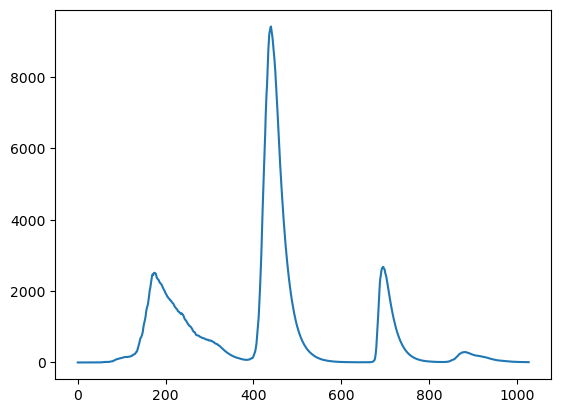

In [27]:
plt.plot(daily_cases.loc['BR',:])

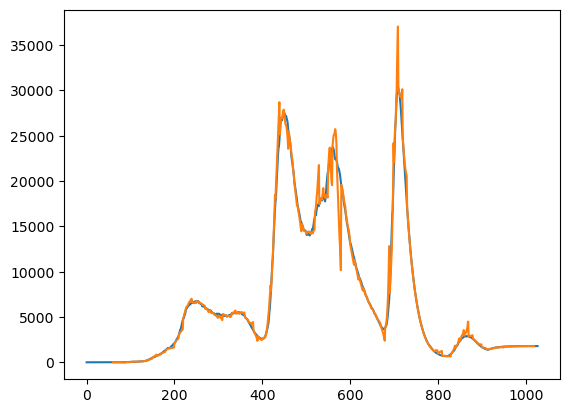

In [34]:
plt.plot(daily_cases.loc['KL',:])
plt.plot(t,y[16,:])
plt.show()

In [55]:
    X=daily_cases
    train_days=120
    pred_days=30
    start_day=50
    d=20
    train_params = {"start_day":start_day, "train_days":train_days, "pred_days":pred_days}
    HODMD_params = { "svd_rank":X.shape[0], "tlsq_rank":0, "exact":False, "opt":False,
                    "rescale_mode":None, "forward_backward":False, "d":d,
                    "sorted_eigs":False, "reconstruction_method":"first",
                    "svd_rank_extra":0}
    exps = []
    preds = []
    exp = Experiment(X,train_params=train_params,HODMD_params=HODMD_params);
    exp.fit();
    preds = exp.pred()
    pred_timesteps = np.arange(train_params["start_day"]+train_params["train_days"],train_params["start_day"]+train_params["train_days"]+ train_params["pred_days"])
    lambdas = mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params["pred_days"] )

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.2557136324116838e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [5]:
def wave_predictor(X,start_day=0,train_days=60,pred_days=30,d=55):
    train_params = {"start_day":start_day, "train_days":train_days, "pred_days":pred_days}
    HODMD_params = { "svd_rank":X.shape[0], "tlsq_rank":0, "exact":False, "opt":False,
                    "rescale_mode":None, "forward_backward":False, "d":d,
                    "sorted_eigs":False, "reconstruction_method":"first",
                    "svd_rank_extra":0}
    exps = []
    preds = []
    exp = Experiment(X,train_params=train_params,HODMD_params=HODMD_params);
    exp.fit();
    preds = exp.pred()
    pred_timesteps = np.arange(train_params["start_day"]+train_params["train_days"],train_params["start_day"]+train_params["train_days"]+ train_params["pred_days"])
    lambdas = mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params["pred_days"] )
    return pred_timesteps,preds
    

(21,)


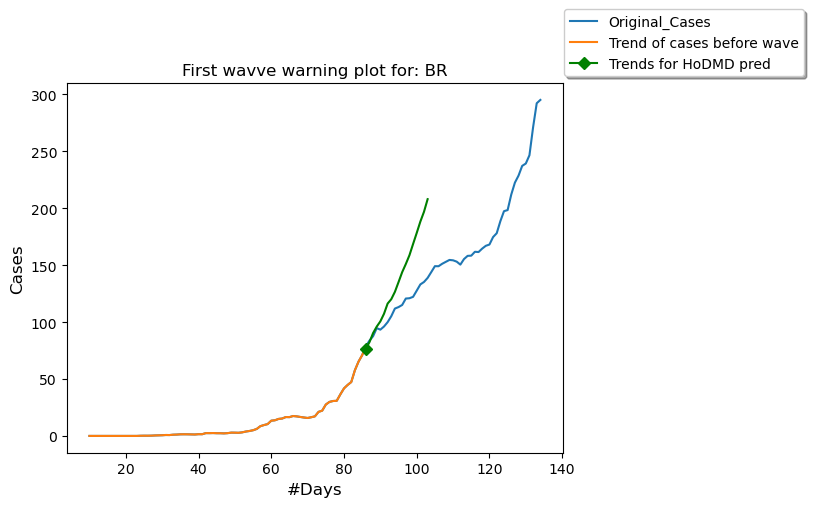

In [11]:
#First Wave starts at aprroximately 75th day
"""
Optimun d=55
start=0
end=66
pred=18
"""
state='BR'
begin_day=10
end_day=76
pred_days=18


state_list = list(states)
idx = state_list.index(state)
t,y=wave_predictor(daily_cases,begin_day,end_day,pred_days)

[h1]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day+pred_days+30],label='Original_Cases')
[h2]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day],label='Trend of cases before wave')
[h3]=plt.plot(t,y[idx,:],'-gD',markevery=end_day,label='Trends for HoDMD pred')
plt.legend(handles=[h1,h2,h3],fontsize=10,loc='lower right',bbox_to_anchor=(1.5,1),shadow=True)
plt.xlabel('#Days',fontsize=12)
plt.ylabel('Cases',fontsize=12)
plt.title(f'First wavve warning plot for: {state}')
plt.show()

(36,)


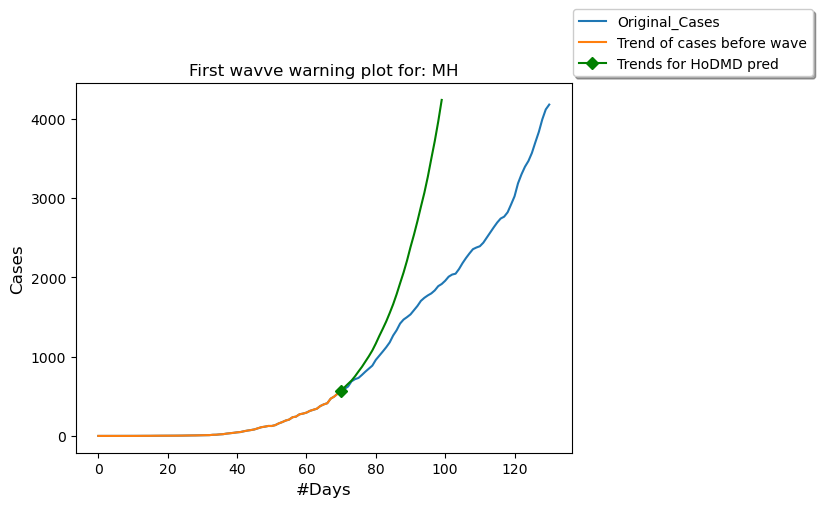

(36,)


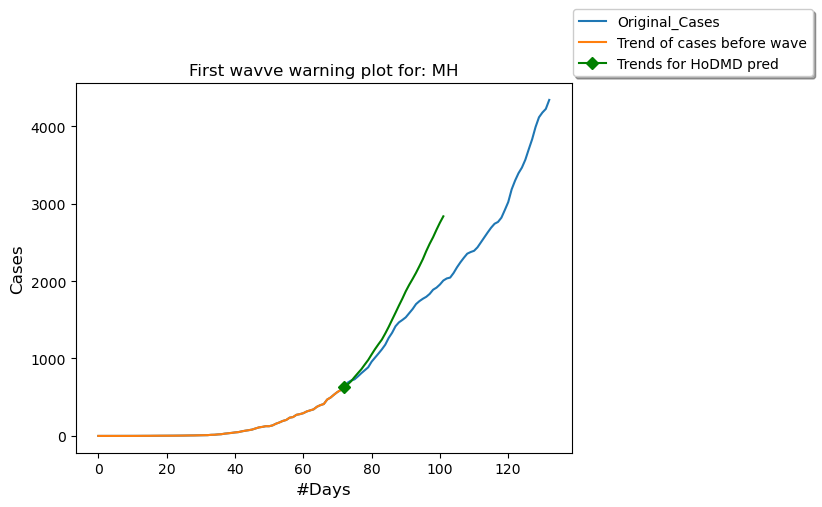

(36,)


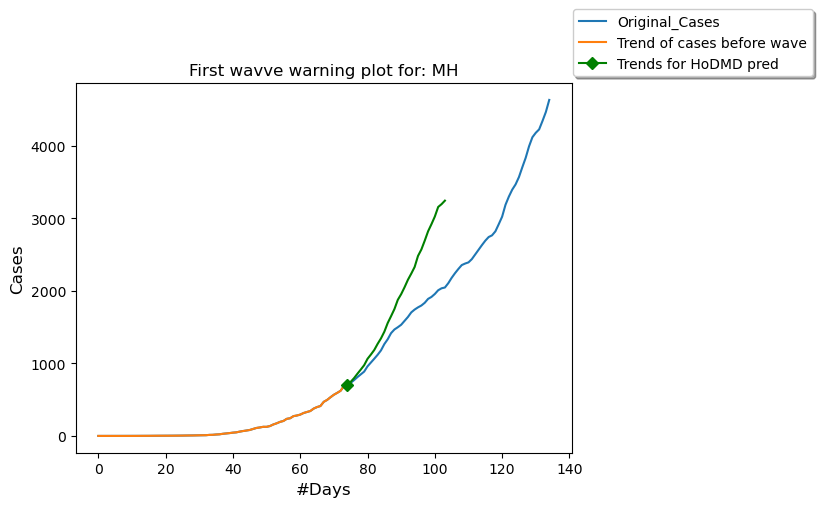

(36,)


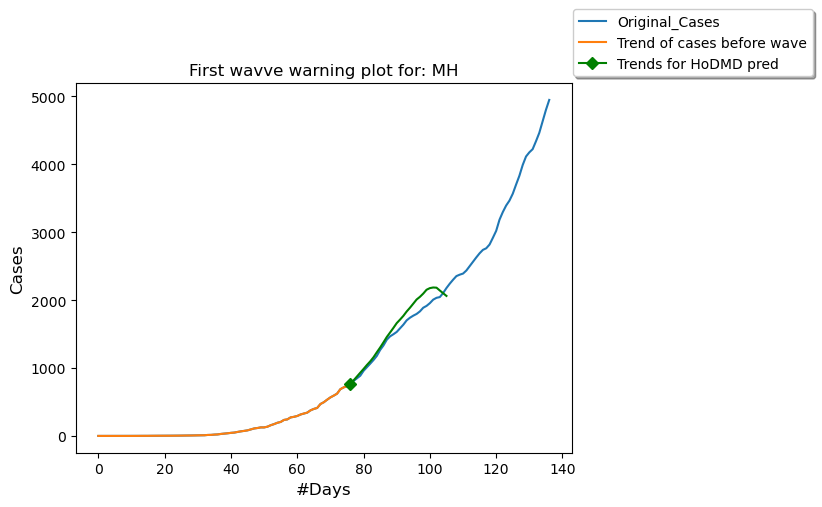

(36,)


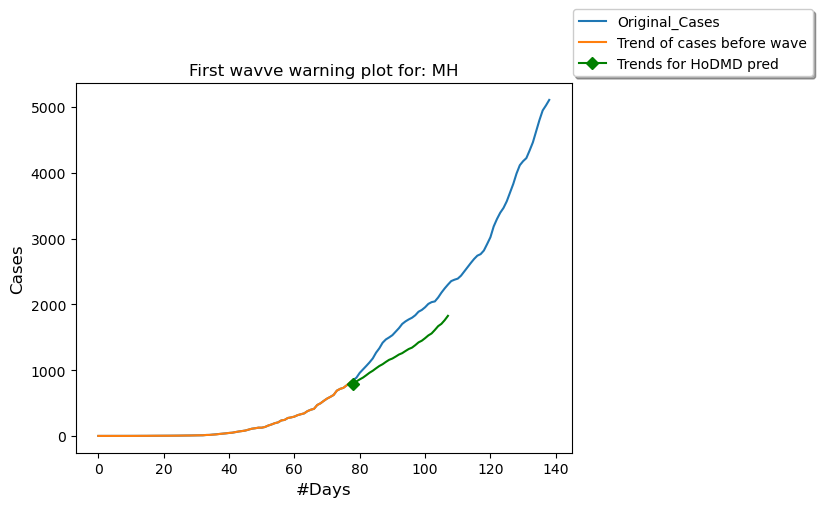

(36,)


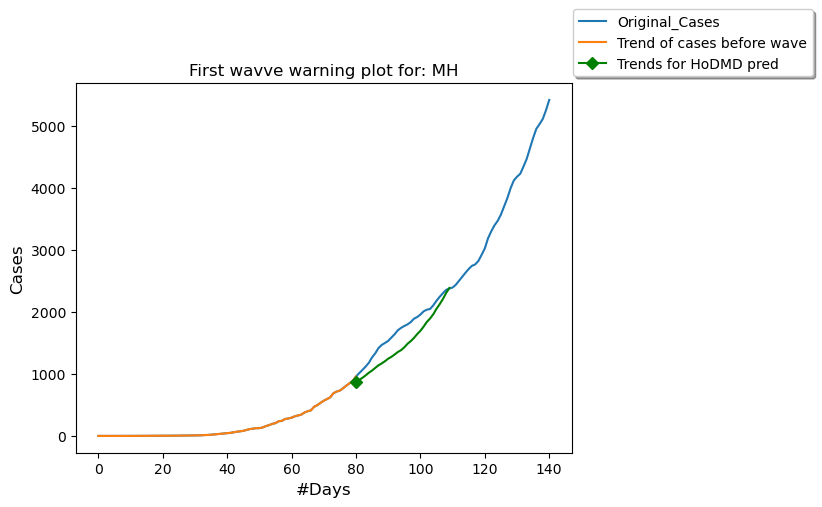

(36,)


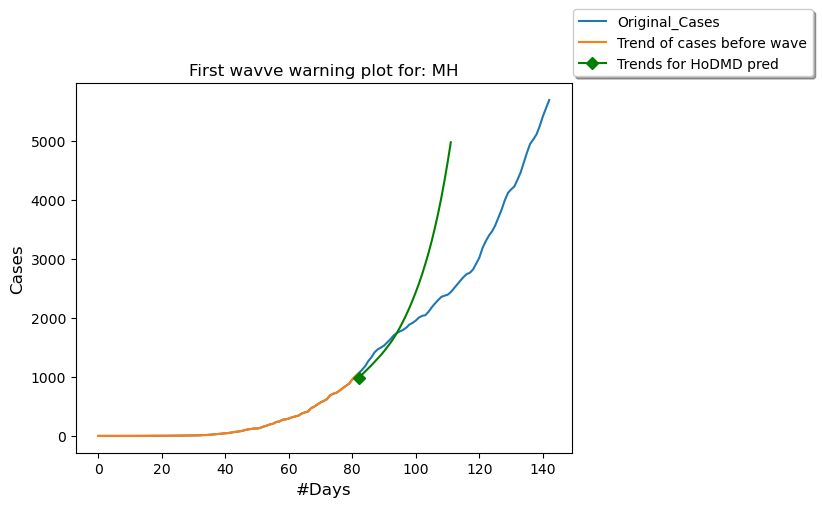

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 3.0405650236762993e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


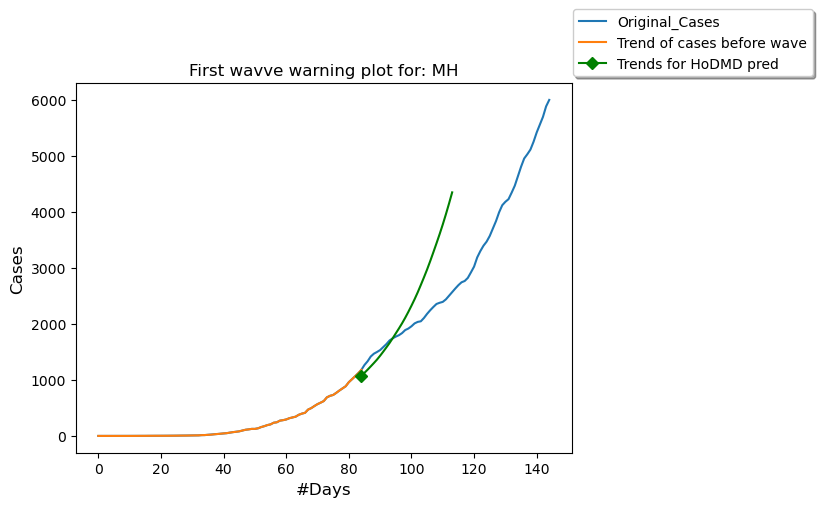

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.441775500832369e+20. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


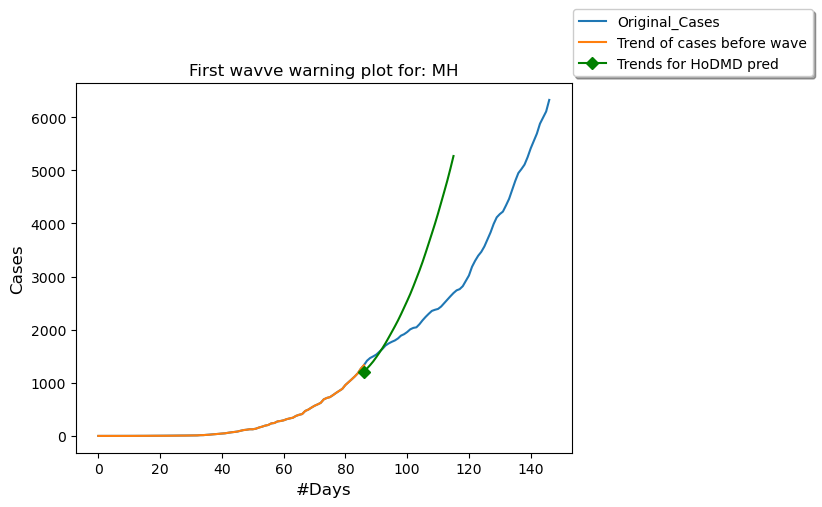

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.814696598042834e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


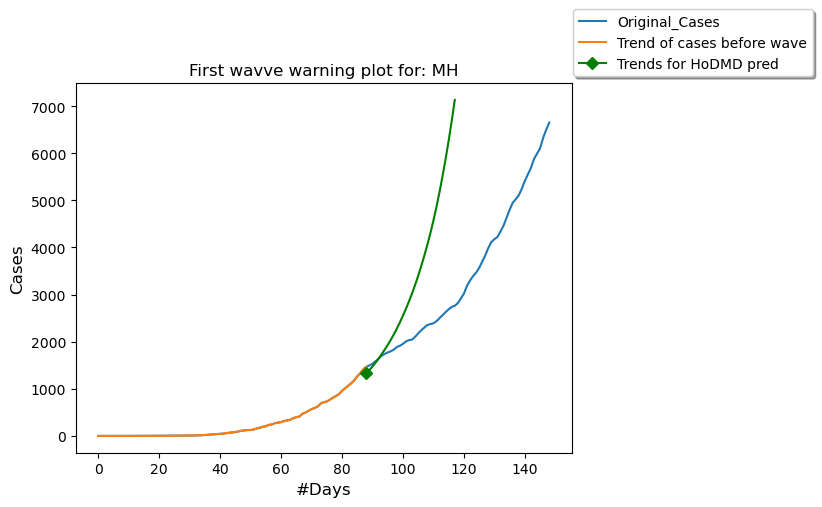

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.599572820107449e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


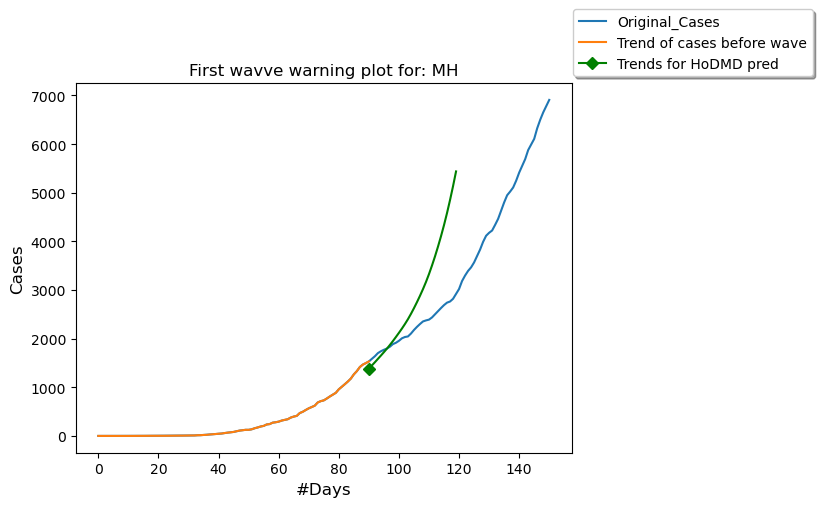

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.385185898586401e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


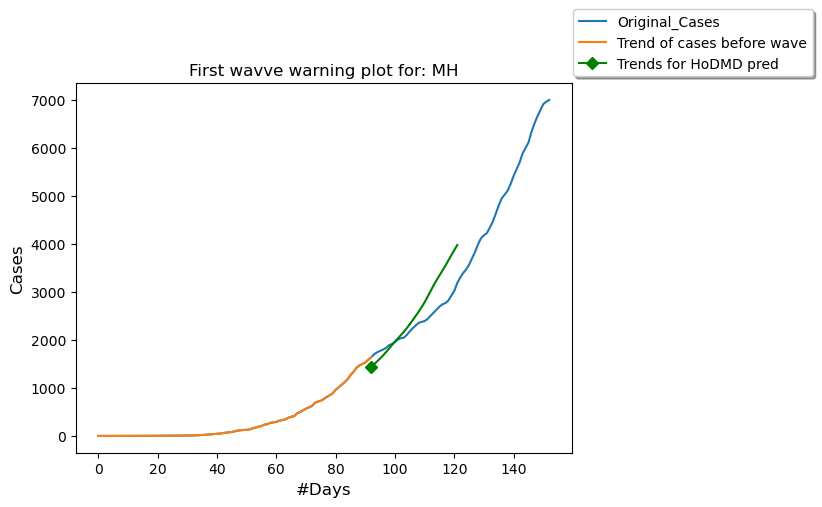

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.1395421127220058e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


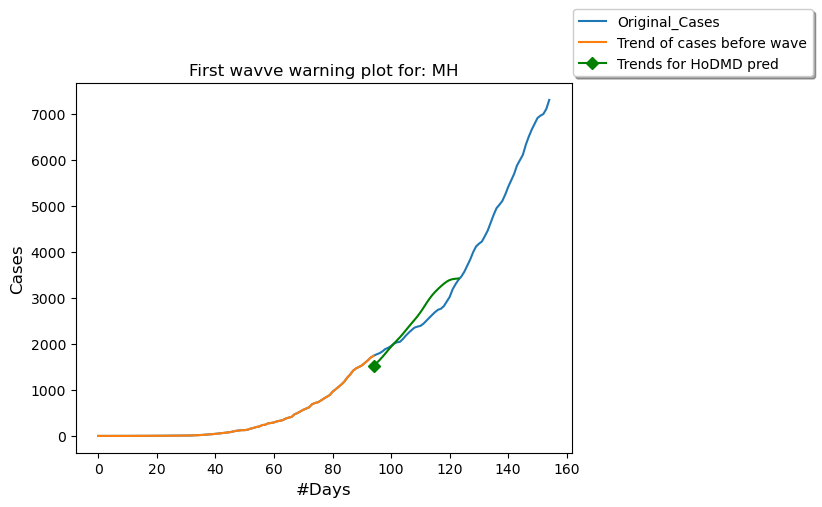

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.184008027470771e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


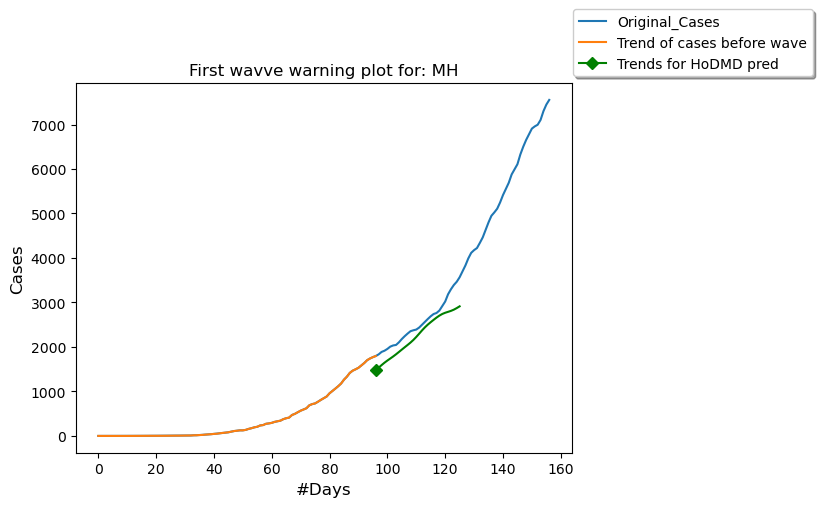

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.063968017735755e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


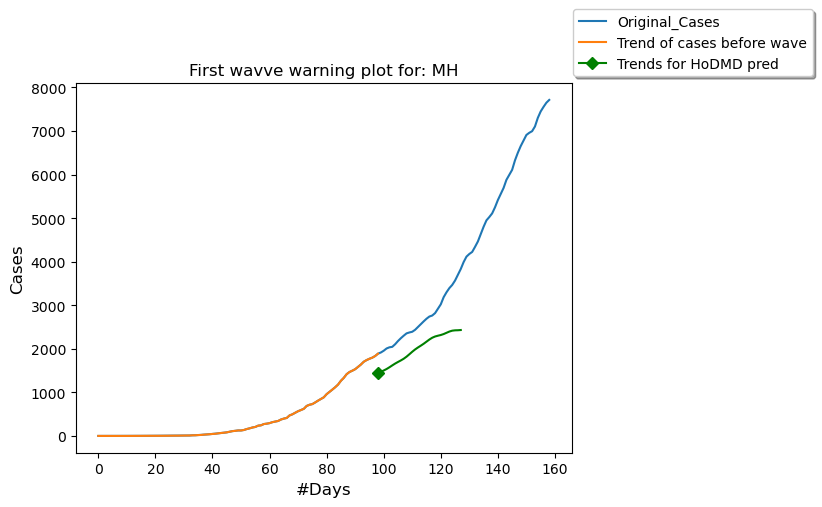

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.308256254298976e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


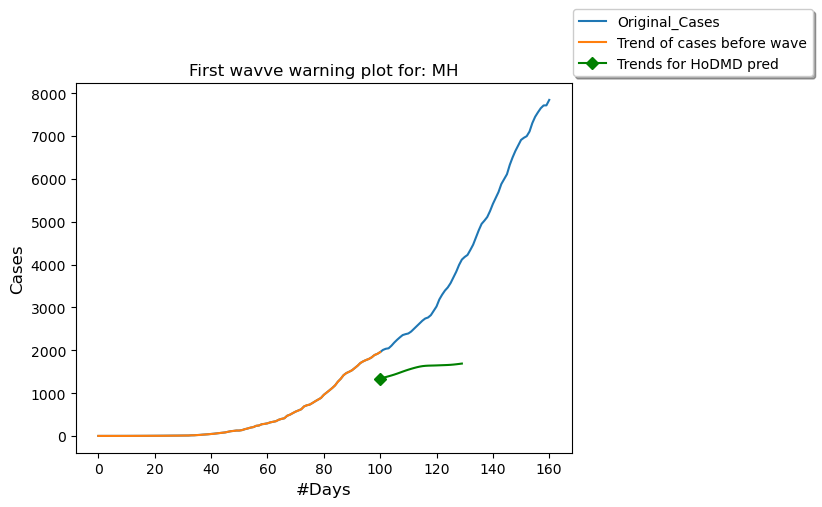

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.0726987465126072e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


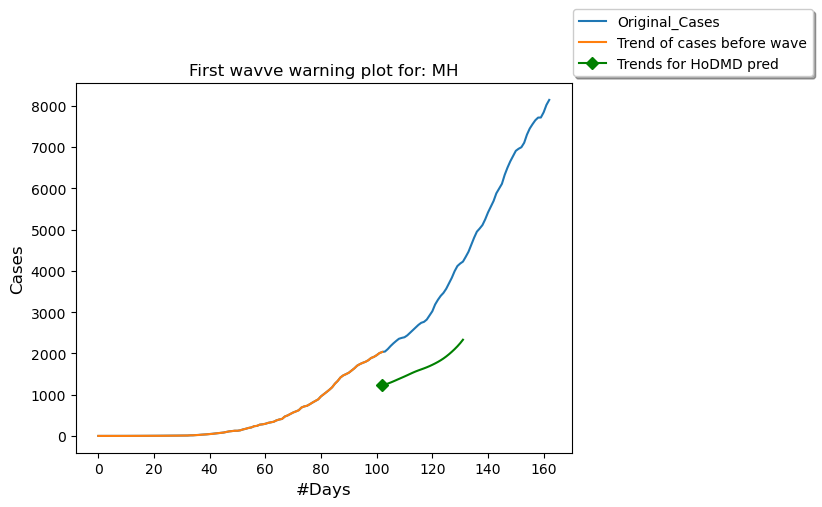

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.973766166052282e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


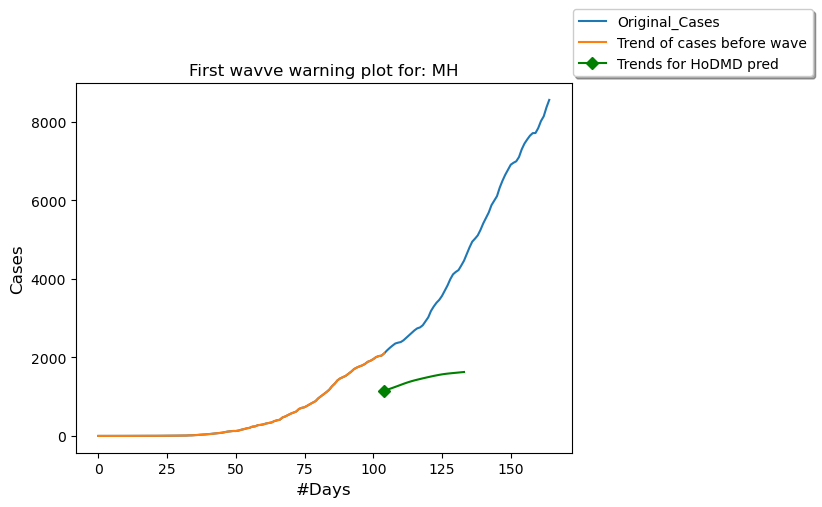

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.551507633279944e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


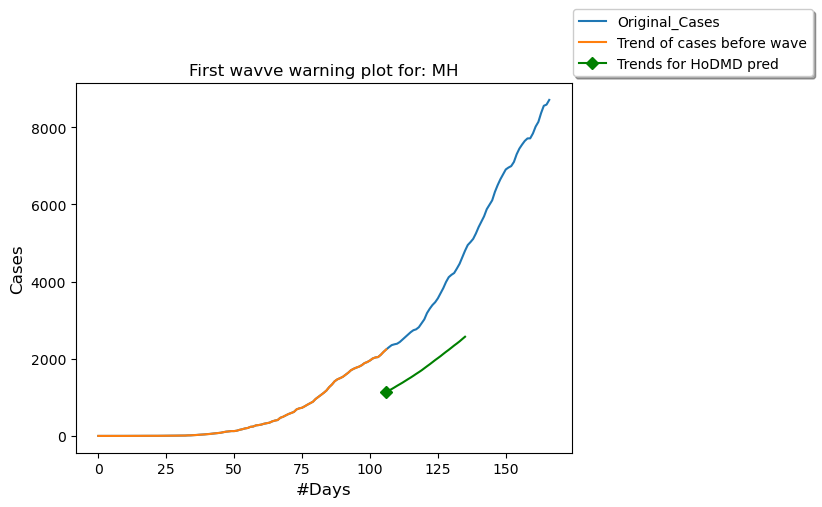

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.838270893074792e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


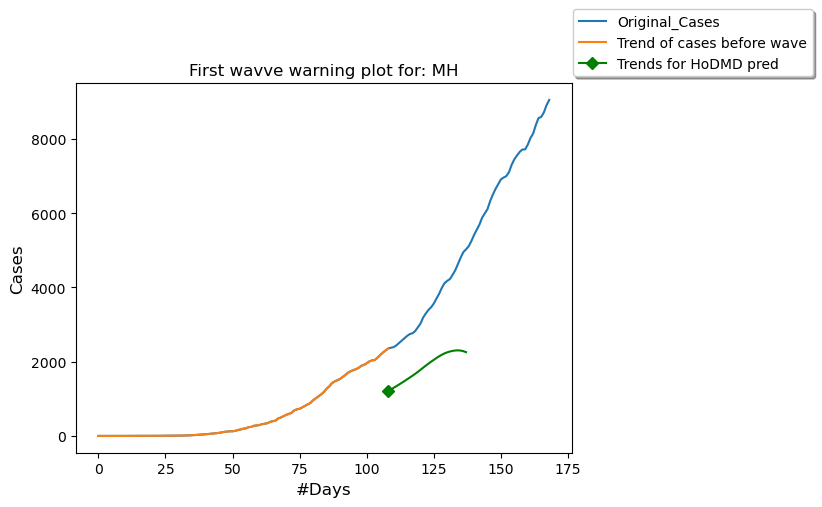

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.681424027689946e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


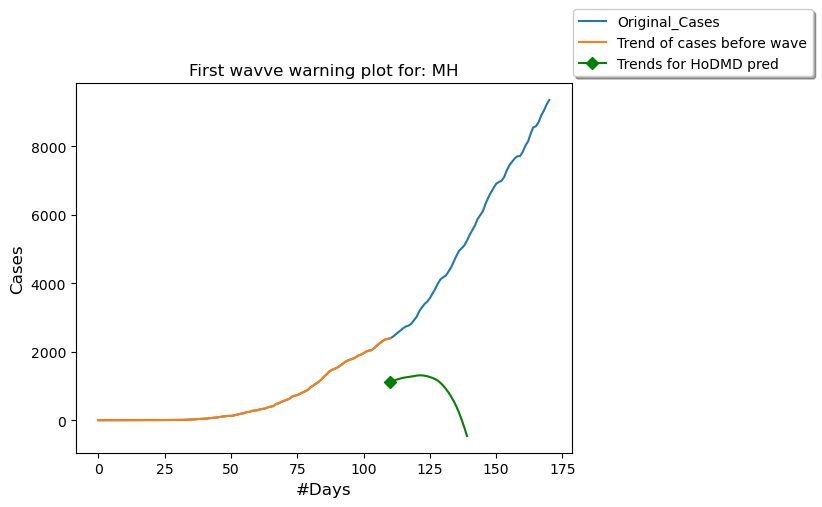

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.935215906427094e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


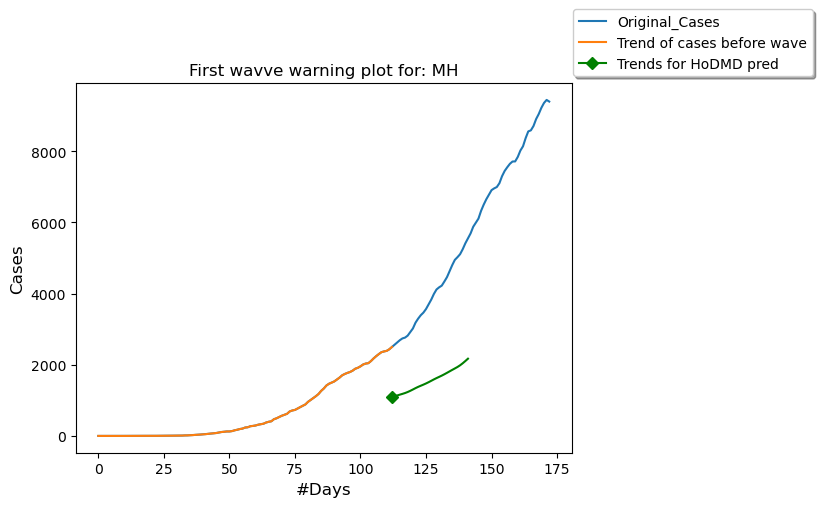

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.0703236990490108e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


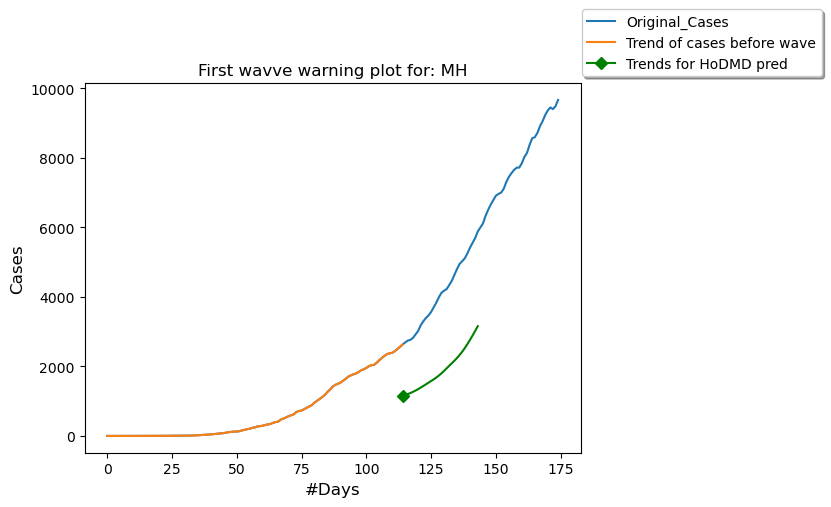

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.674475152425982e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


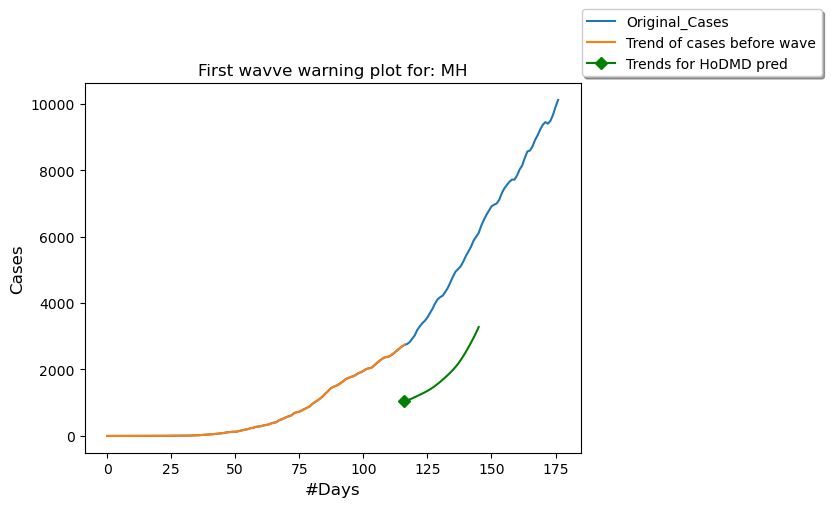

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.850493155610233e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


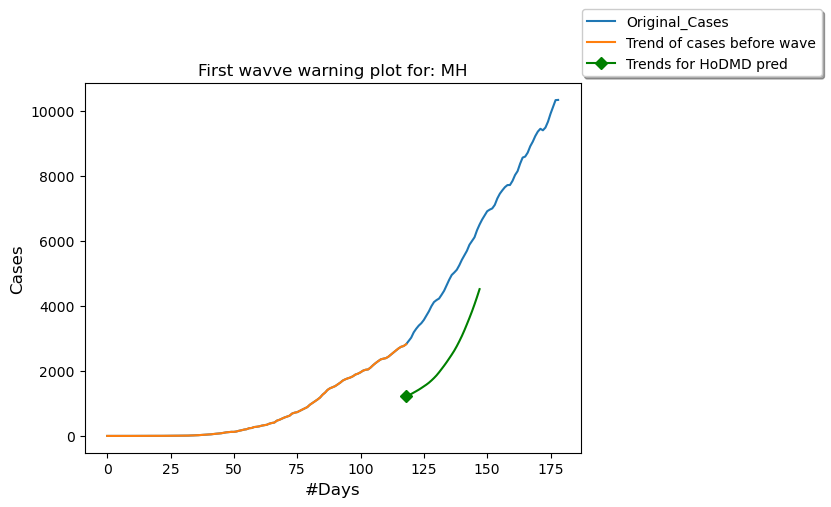

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1.033037852636669e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


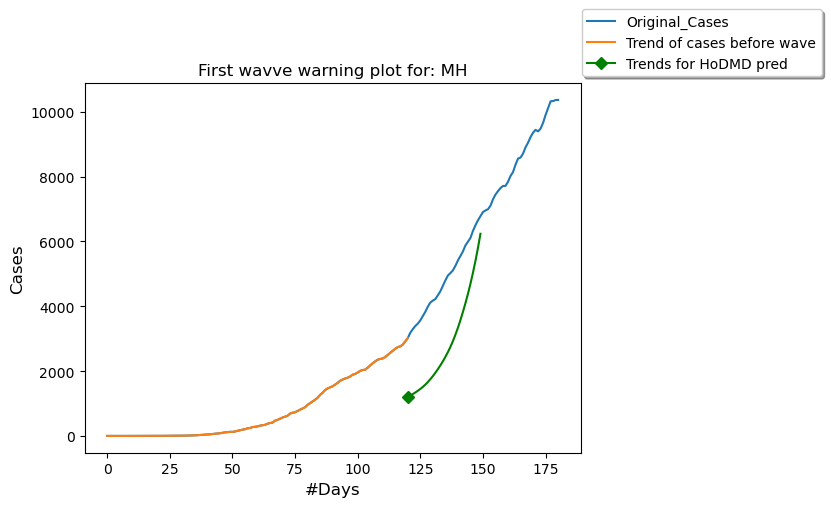

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.661909542788902e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


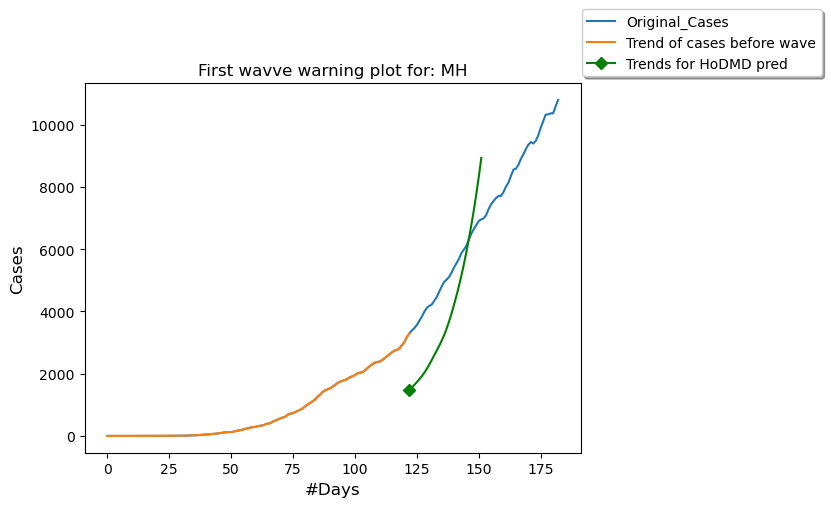

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.131044706373231e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


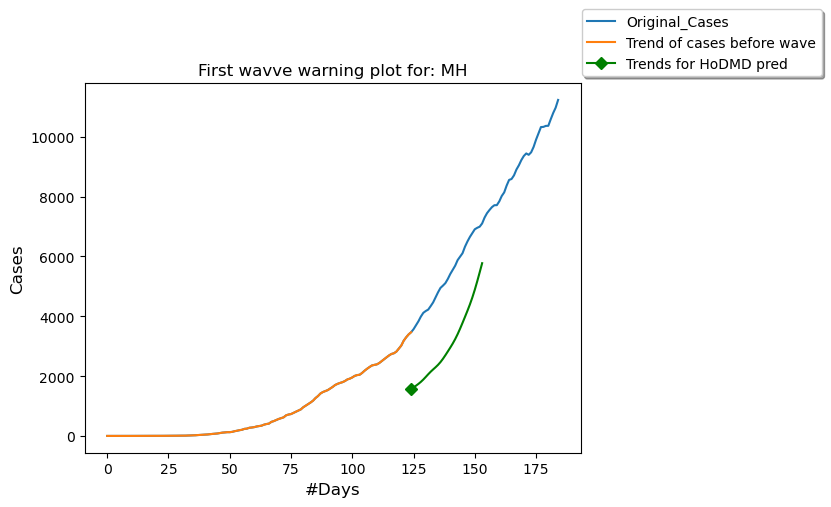

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.931382245938023e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


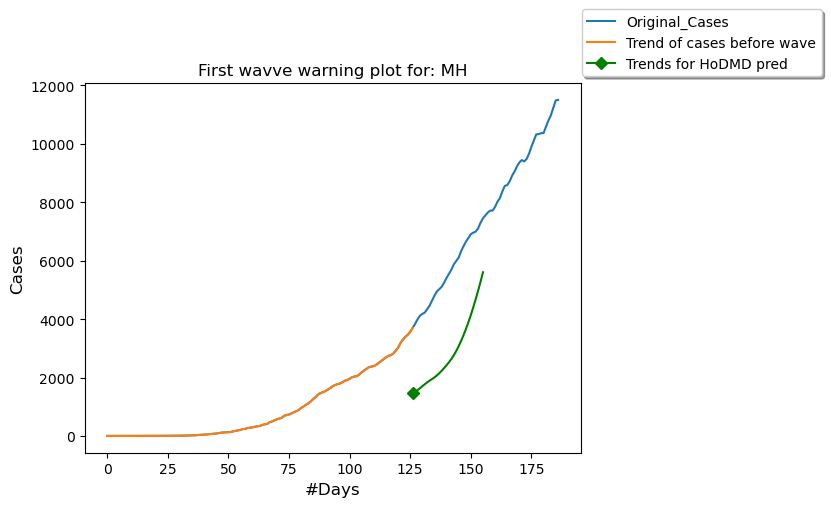

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.666520460551762e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


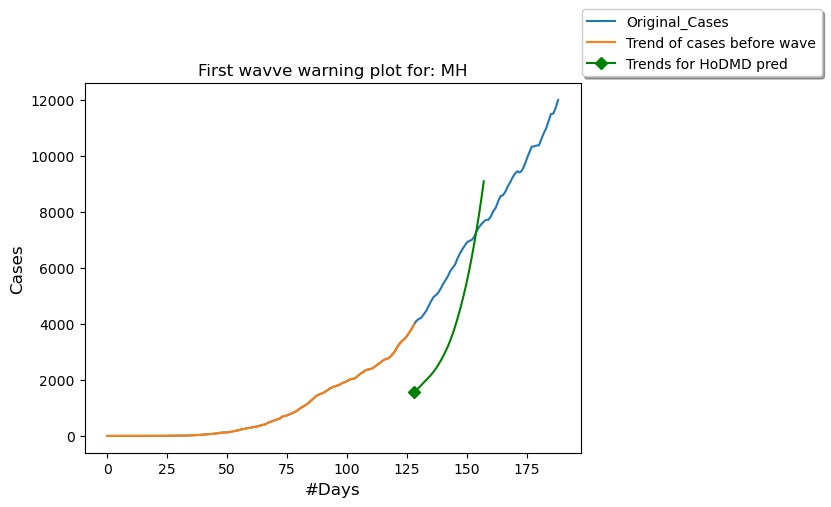

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.857432543358075e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


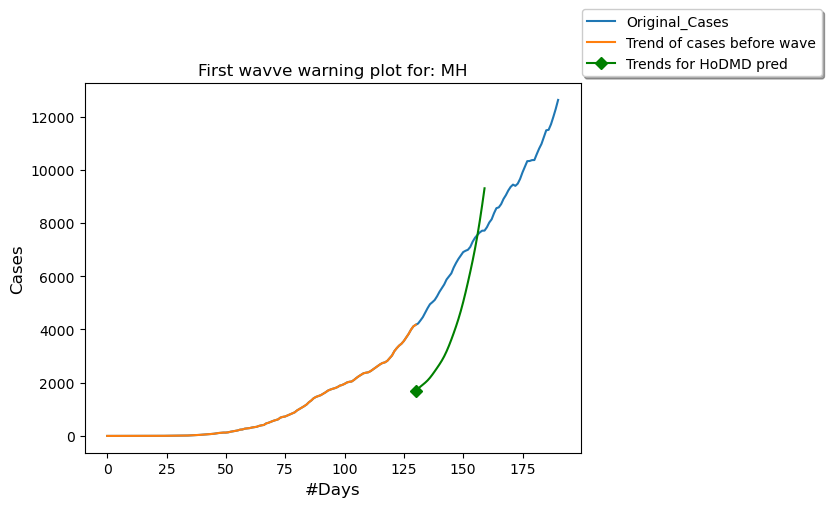

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.547754449533905e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


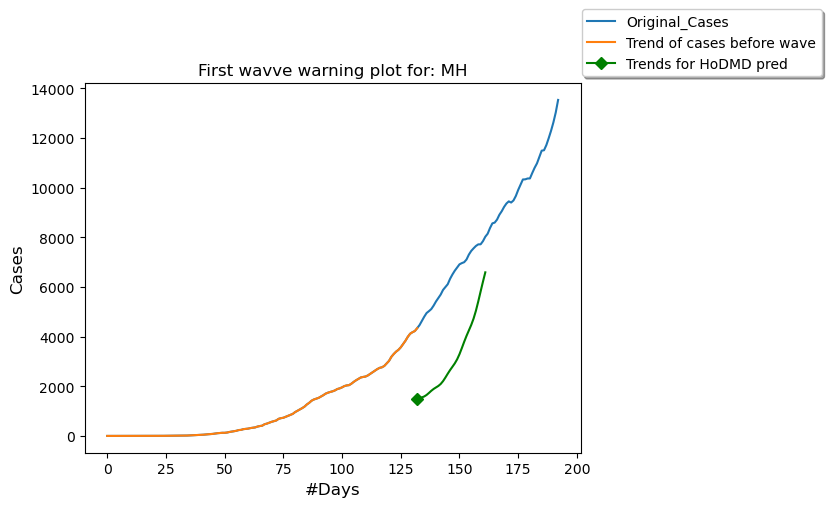

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.235730010659139e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


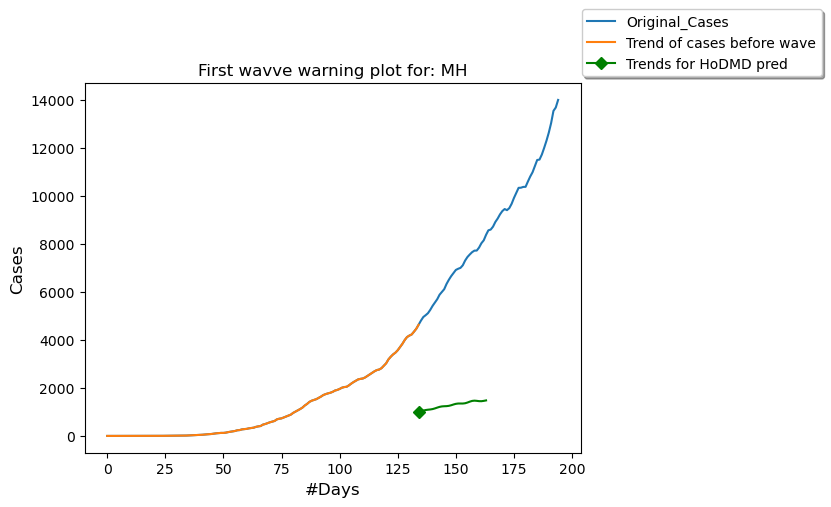

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.021268573110454e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


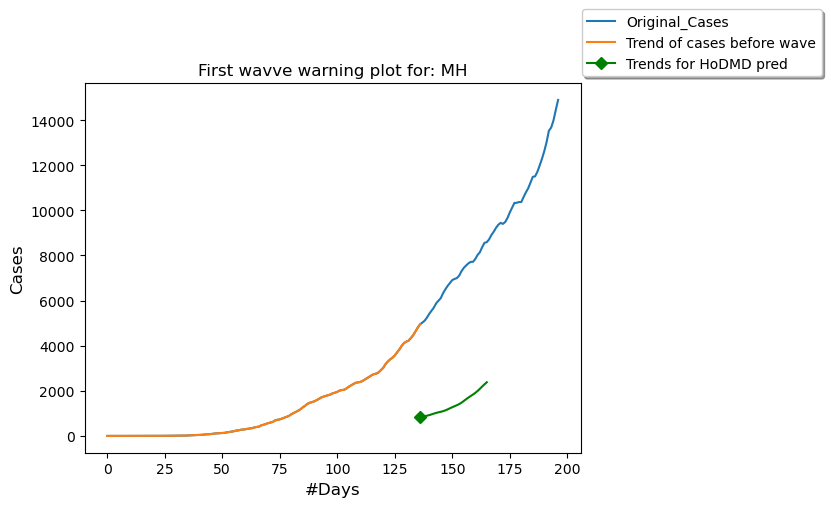

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 5.992943165689997e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


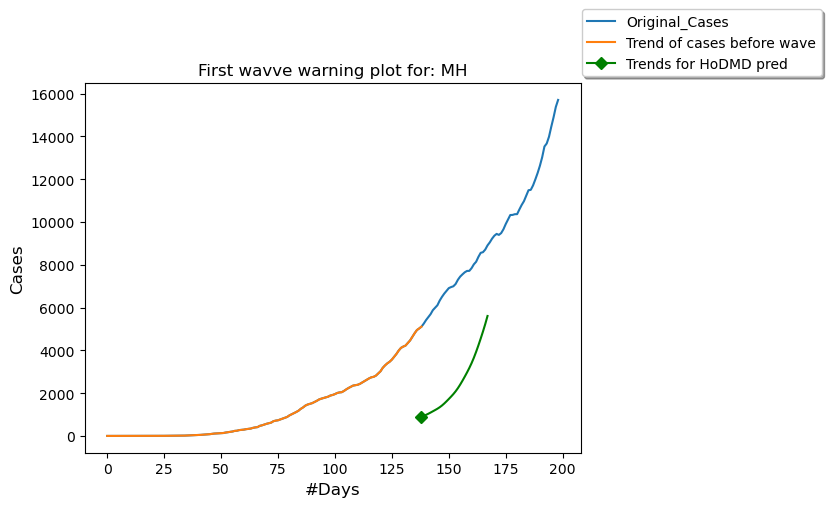

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.501017496392815e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


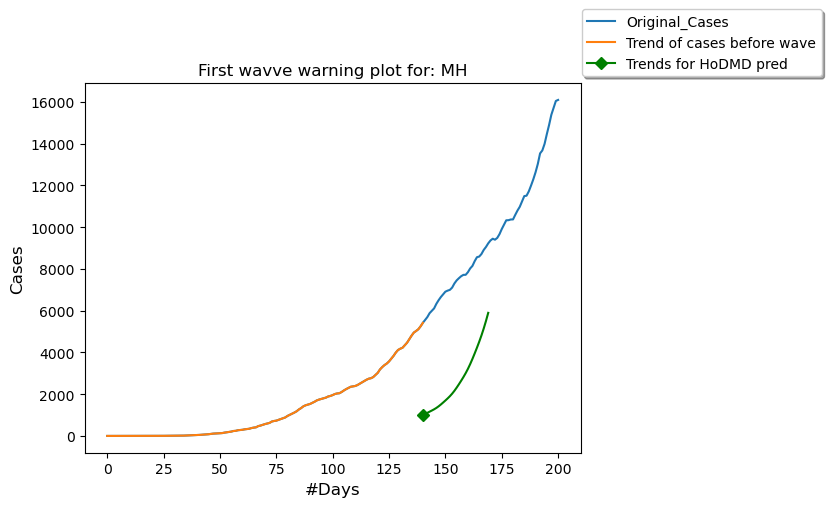

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.181412172930838e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


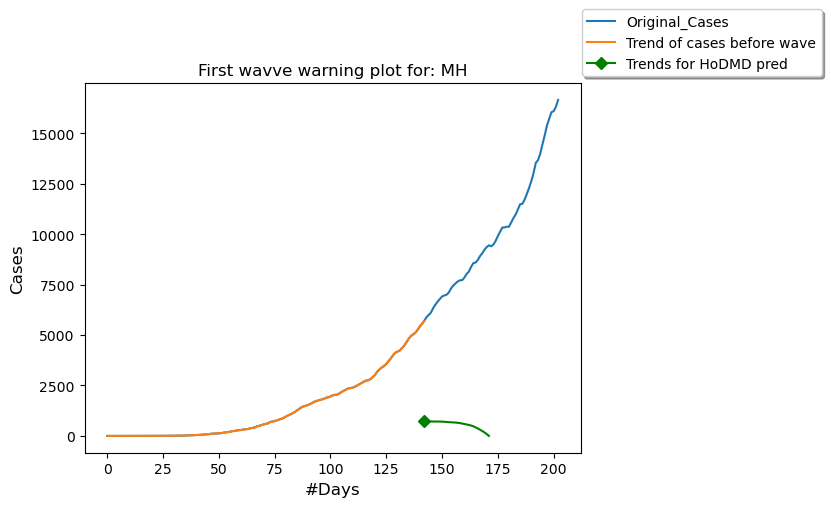

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 6.206244414602809e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(36,)


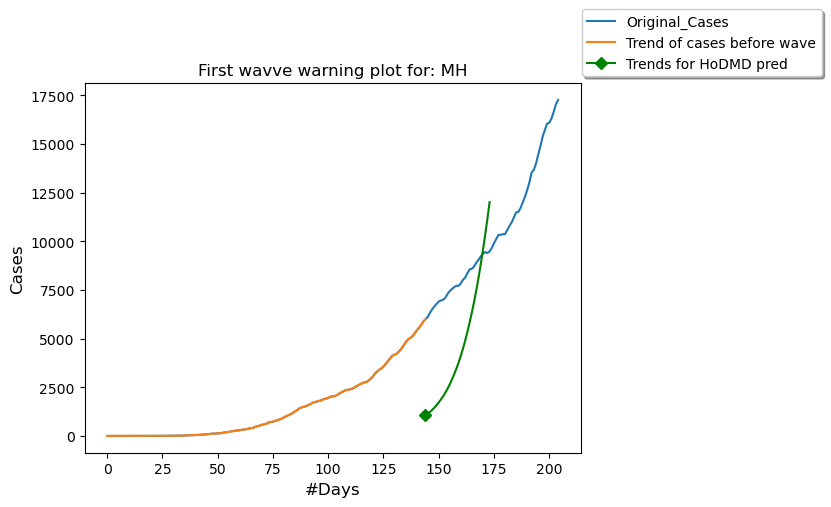

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 7.388099572003333e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


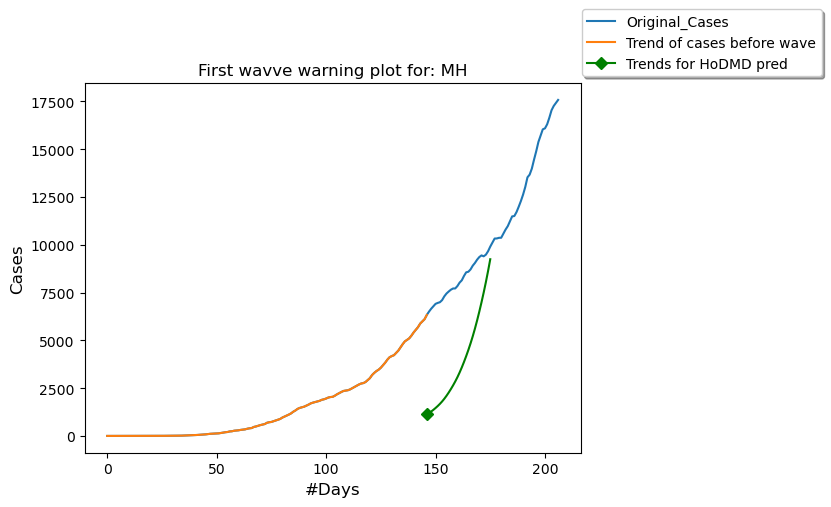

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 9.494299589022724e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


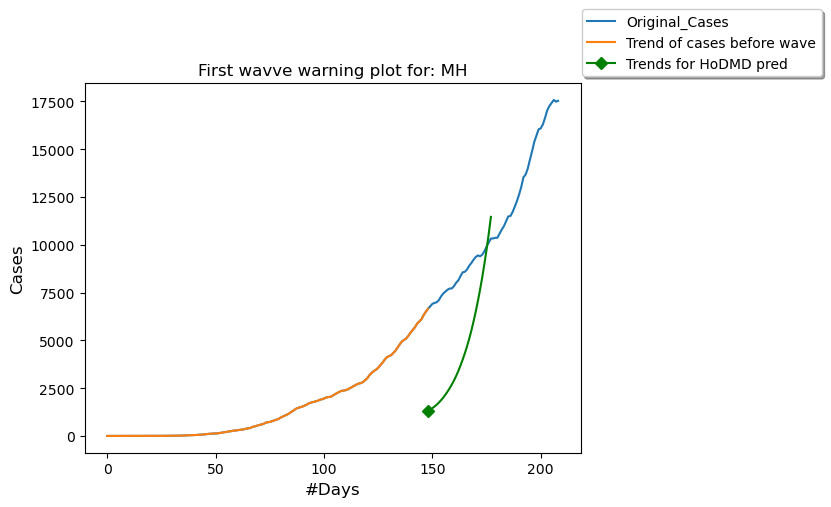

(36,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 8.854580746413525e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


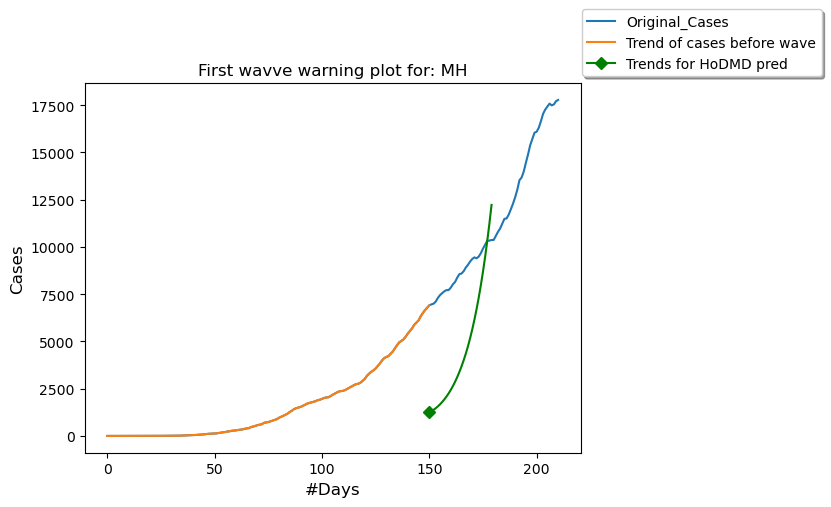

In [152]:
end_day=70
while(end_day<=150):
    state='MH'
    begin_day=0
    pred_days=30
    i=1

    state_list = list(states)
    idx = state_list.index(state)
    t,y=wave_predictor(daily_cases,begin_day,end_day,pred_days)

    [h1]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day+pred_days+30],label='Original_Cases')
    [h2]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day],label='Trend of cases before wave')
    [h3]=plt.plot(t,y[idx,:],'-gD',markevery=end_day,label='Trends for HoDMD pred')
    plt.legend(handles=[h1,h2,h3],fontsize=10,loc='lower right',bbox_to_anchor=(1.5,1),shadow=True)
    plt.xlabel('#Days',fontsize=12)
    plt.ylabel('Cases',fontsize=12)
    plt.title(f'First wavve warning plot for: {state}')
    plt.show()
    plt.savefig(f'img_{i}.png')
    plt.close()
    end_day=end_day+2
    i=i+1

In [ ]:
frames=[]
t=1
import imageio
while(t<=i):
    img=imageio.v2.imread(f'img_{t}.png')
    frames.append(img)

In [ ]:
imageio.mimsave('example.gif',frames,fps = 5)         

(11,)


C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 1150682110.5356705. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


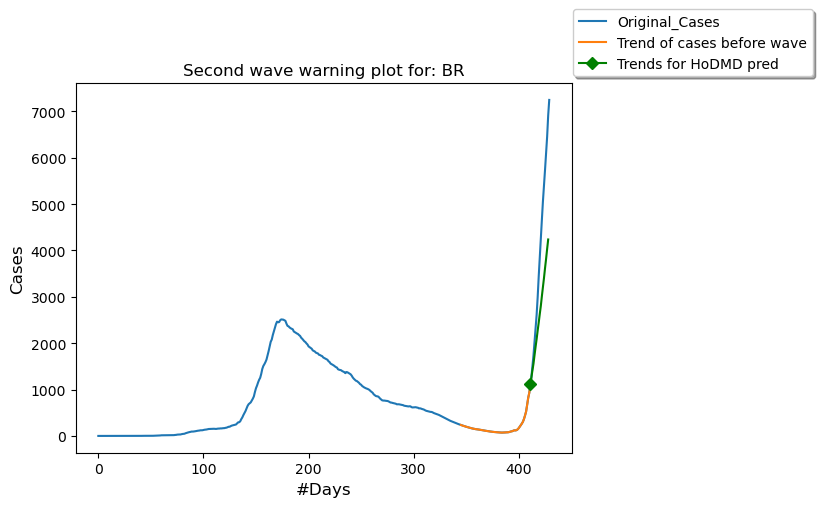

In [34]:
#Second Wave starts at aprroximately 350th day 
"""
Optimun d=55
start=0
end=66
pred=18
"""
state='BR'
begin_day=345
end_day=66
pred_days=18


state_list = list(states)
idx = state_list.index(state)
t,y=wave_predictor(daily_cases,begin_day,end_day,pred_days)

[h1]=plt.plot(daily_cases.loc[state,0:begin_day+end_day+pred_days],label='Original_Cases')
[h2]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day],label='Trend of cases before wave')
[h3]=plt.plot(t,y[idx,:],'-gD',markevery=end_day,label='Trends for HoDMD pred')
plt.legend(handles=[h1,h2,h3],fontsize=10,loc='lower right',bbox_to_anchor=(1.5,1),shadow=True)
plt.xlabel('#Days',fontsize=12)
plt.ylabel('Cases',fontsize=12)
plt.title(f'Second wave warning plot for: {state}')
plt.show()

C:\Users\Vishnu\anaconda3\lib\site-packages\pydmd\dmdbase.py:715: UserWarning: Input data matrix X has condition number 311542984448806.7. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(11,)


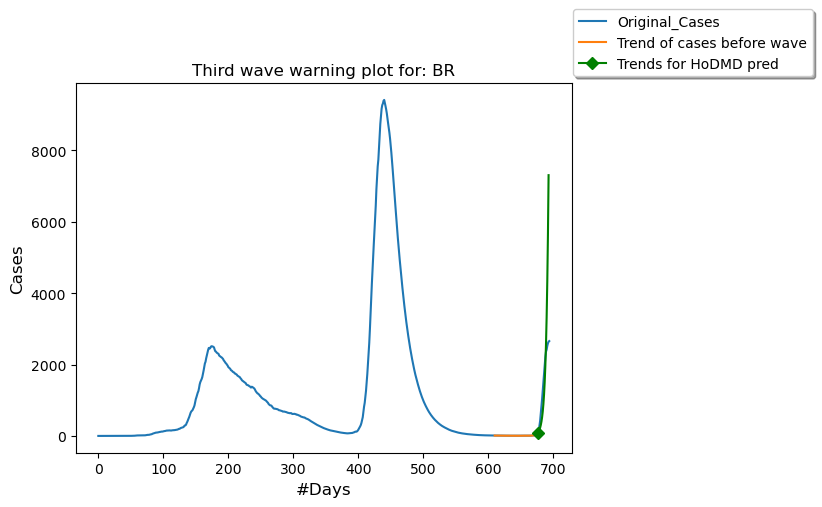

In [25]:
#Third Wave starts at aprroximately 600th day 
state='BR'
begin_day=610
end_day=66
pred_days=18


state_list = list(states)
idx = state_list.index(state)
t,y=wave_predictor(daily_cases,begin_day,end_day,pred_days)

[h1]=plt.plot(daily_cases.loc[state,0:begin_day+end_day+pred_days],label='Original_Cases')
[h2]=plt.plot(daily_cases.loc[state,begin_day:begin_day+end_day],label='Trend of cases before wave')
[h3]=plt.plot(t,y[idx,:],'-gD',markevery=end_day,label='Trends for HoDMD pred')
plt.legend(handles=[h1,h2,h3],fontsize=10,loc='lower right',bbox_to_anchor=(1.5,1),shadow=True)
plt.xlabel('#Days',fontsize=12)
plt.ylabel('Cases',fontsize=12)
plt.title(f'Third wave warning plot for: {state}')
plt.show()